# Organize figures

## Figure 1

### a. speckle size & speckle imag

experimental conditions: 20% wt HS gel, imaged at HCBI.

1. speckle size vs. objective NA
2. speckle size vs. pinhole size

#### 1 . speckle size vs. objective NA

In [1]:
import speckle
from speckle.inference.read_in_data import read_in_data
from speckle.inference.correlation_heatmap import get_correlation,dump_heatmap,display_correlation_heatmaps,mask_heatmap,plot_radius_distribution
from speckle.inference.calculating_tau import objective, avg_correlation_single_px, plot_correlation_vs_lagtime,fit_exponential_decay, reconstruct,avg_correlation,calculate_correlation_pixel
from speckle.inference.dedrift import dedrift_videos

In [2]:
from skimage import io
import matplotlib.pyplot as plt
import seaborn as sns
import math
import copy
import numpy as np
from scipy.optimize import curve_fit
import math
from operator import itemgetter

In [3]:
def spatial_correlation(example_img, sp_shape,ROI):
    y_length=example_img.shape[0]
    x_length=example_img.shape[1]
    num_pixels=y_length*x_length
    spcorrelation_map = np.zeros((sp_shape,sp_shape))
    for dy in range(-math.floor(sp_shape/2), math.floor(sp_shape/2), 1):
        for dx in range(-math.floor(sp_shape/2), math.floor(sp_shape/2), 1):
            sum_numerator=0
            sum_denum_1=0
            sum_denum_2=0
            count=0
            for y in range(ROI[0],ROI[0]+ROI[2],1):
                for x in range(ROI[1],ROI[1]+ROI[3],1):
                    sum_numerator+=int(example_img[y][x])*int(example_img[y+dy][x+dx])
                    sum_denum_1+=int(example_img[y][x])
                    sum_denum_2+=int(example_img[y+dy][x+dx])
                    count+=1
            numerator=sum_numerator/count
            denum_1=sum_denum_1/count
            denum_2=sum_denum_2/count
            spcorrelation_map[dy+math.floor(sp_shape/2)][dx+math.floor(sp_shape/2)]=copy.deepcopy(numerator/(denum_1*denum_2)-1)
    normalization=spcorrelation_map[math.floor(sp_shape/2)][math.floor(sp_shape/2)]
    spcorrelation_map=spcorrelation_map/normalization
    sns.heatmap(spcorrelation_map)
    return spcorrelation_map

In [4]:
def plot_spmap(spcorrelation_map):
    xv, yv = np.meshgrid(np.arange(-math.floor(spcorrelation_map.shape[0]/2),math.floor(spcorrelation_map.shape[0]/2),1),np.arange(-math.floor(spcorrelation_map.shape[1]/2),math.floor(spcorrelation_map.shape[1]/2),1))
    radius = np.sqrt(xv**2 + yv**2)
    radius_flatten=np.array(np.concatenate(radius).flat)
    spcorrelation_map_flatten=np.array(np.concatenate(spcorrelation_map).flat)
    plt.plot(radius_flatten,spcorrelation_map_flatten,'.')
    plt.legend(['Correlation vs delta r'], fontsize=18)
    plt.xlabel("delta r [pixels]",fontsize=18)
    plt.ylabel("Correlation",fontsize=18)
    plt.show

In [5]:
def calculate_speckle_size(spcorrelation_map,startidx,endidx,plotBoolean=True):
    xv, yv = np.meshgrid(np.arange(-math.floor(spcorrelation_map.shape[0]/2),math.floor(spcorrelation_map.shape[0]/2),1),np.arange(-math.floor(spcorrelation_map.shape[1]/2),math.floor(spcorrelation_map.shape[1]/2),1))
    radius = np.sqrt(xv**2 + yv**2)
    radius_flatten=np.array(np.concatenate(radius).flat)
    spcorrelation_map_flatten=np.array(np.concatenate(spcorrelation_map).flat)
    radius_squared=radius_flatten*radius_flatten
    log_correlation=np.log(abs(spcorrelation_map_flatten))
    combined_list=[]
    combined_list.append(radius_squared)
    combined_list.append(log_correlation)
    combined_list=np.array(combined_list)
    combined_list_sorted=np.array(sorted(combined_list.transpose(),key=lambda lst:lst[1],reverse=True)).transpose()
    if plotBoolean==True:
        x, y = combined_list_sorted[0][startidx:endidx], combined_list_sorted[1][startidx:endidx]
        # curve fit
        popt, _ = curve_fit(objective, x, y)
        # summarize the parameter values
        a, b= popt
        print("speckle size is:",np.sqrt(-1/a))
        print('y = %.5f * x' % (a))
        # plot input vs output
        plt.scatter(x, y)
        
        # define a sequence of inputs between the smallest and largest known inputs
        x_line = np.arange(min(x), max(x), 1)
        # calculate the output for the range
        y_line = objective(x_line, a, b)
        # create a line plot for the mapping function
        plt.plot(x_line, y_line, '--', color='red')
        plt.show()
        return np.sqrt(-1/a),a
    else:
        x, y = combined_list_sorted[0][0:20], combined_list_sorted[1][0:20]
        # curve fit
        popt, _ = curve_fit(objective, x, y)
        # summarize the parameter values
        a= popt
        return np.sqrt(-1/a)

def objective(x, a, b):
	return a * x + b

In [6]:
def reconstruct_curve(spcorrelation_map,a):
    xv, yv = np.meshgrid(np.arange(-math.floor(spcorrelation_map.shape[0]/2),math.floor(spcorrelation_map.shape[0]/2),1),np.arange(-math.floor(spcorrelation_map.shape[1]/2),math.floor(spcorrelation_map.shape[1]/2),1))
    radius = np.sqrt(xv**2 + yv**2)
    radius_flatten=np.concatenate(radius).flat
    spcorrelation_map_flatten=np.concatenate(spcorrelation_map).flat
    y=np.zeros(len(radius_flatten))
    for i in range(0, len(radius_flatten),1):
        y[i]=(math.exp(a*radius_flatten[i]))
    plt.figure(figsize=(8,5))
    plt.plot(radius_flatten,y,'*',label="fit line")
    plt.plot(radius_flatten,spcorrelation_map_flatten,'.',label="data")
    plt.legend(['Correlation vs Delta r'], fontsize=18)
    plt.xlabel("Delta r [pixel]",fontsize=18)
    plt.ylabel("Correlation",fontsize=18)
    plt.legend(fontsize=18)

### 10x theoretical

In [40]:
#theoretical:
n=1
lam=405
theoretical=0.5*lam/0.45
print(theoretical)

450.0


In [53]:
#theoretical:
n=1
lam=639
theoretical=0.44*lam/0.45
print(theoretical)

624.8000000000001


#### 405 nm

##### 10x 0.52au

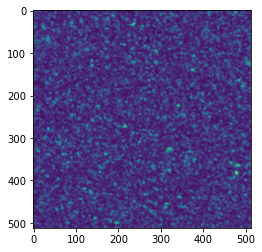

In [102]:
## Load in data
imgname='20p_HSgel_405laser_0p52au_10xobj_singledir_2xavg'
foldername='/Volumes/WENYUN WANG/20221129/gel_20p_HS/'
#framespeed=video_time_length/video_frame_numbers
img=read_in_data(foldername,imgname)

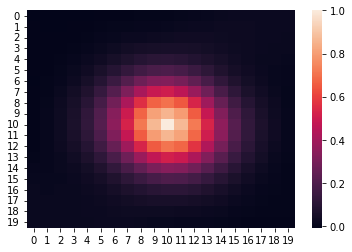

In [103]:
img_20=img[20]
ROI=[0,0,500,200] #y,x,w,h
sp_shape=20
spmap=spatial_correlation(img_20,sp_shape,ROI)

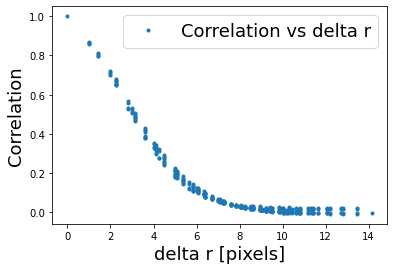

In [104]:
plot_spmap(spmap)

speckle size is: 4.1401750475177135
y = -0.05834 * x


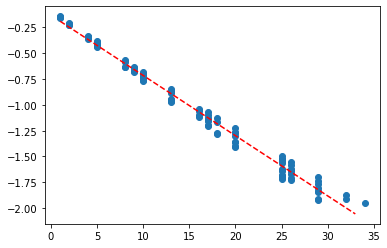

In [105]:
size,a =calculate_speckle_size(spmap,1,100)

In [106]:
scale=9.0509
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :4.1401750475177135 pixel
The size is :0.4574324152866249 um


##### 10x 0.26 au

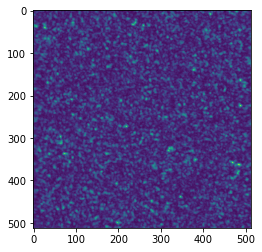

In [107]:
## Load in data
imgname='20p_HSgel_405laser_0p26au_10xobj_singledir_2xavg'
foldername='/Volumes/WENYUN WANG/20221129/gel_20p_HS/'
#framespeed=video_time_length/video_frame_numbers
img=read_in_data(foldername,imgname)

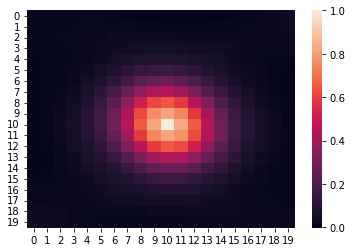

In [108]:
img_20=img[20]
ROI=[0,0,300,200] #y,x,w,h
sp_shape=20
spmap=spatial_correlation(img_20,sp_shape,ROI)

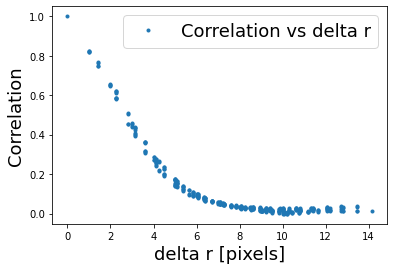

In [109]:
plot_spmap(spmap)

speckle size is: 3.721465832417853
y = -0.07221 * x


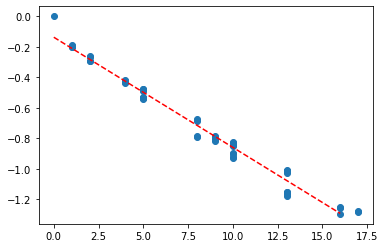

In [110]:
size,a =calculate_speckle_size(spmap,0,50)

In [111]:
scale=9.0509
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :3.721465832417853 pixel
The size is :0.41117080427558067 um


##### 10x 0.78 au

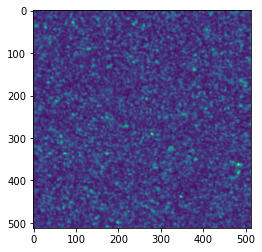

In [112]:
## Load in data
imgname='20p_HSgel_405laser_0p78au_10xobj_singledir_2xavg'
foldername='/Volumes/WENYUN WANG/20221129/gel_20p_HS/'
#framespeed=video_time_length/video_frame_numbers
img=read_in_data(foldername,imgname)

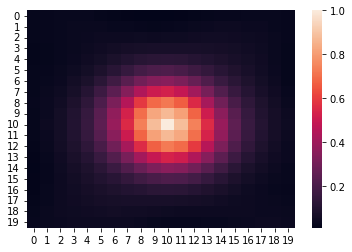

In [113]:
img_20=img[20]
ROI=[0,0,300,200] #y,x,w,h
sp_shape=20
spmap=spatial_correlation(img_20,sp_shape,ROI)

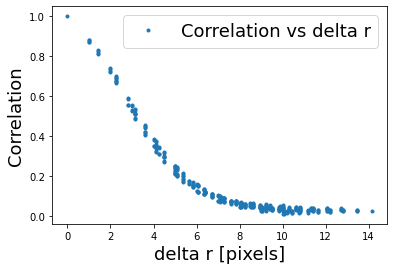

In [114]:
plot_spmap(spmap)

speckle size is: 4.318684483324243
y = -0.05362 * x


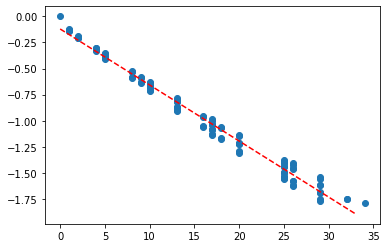

The size is :4.318684483324243 pixel
The size is :0.4771552534360387 um


In [115]:
size,a =calculate_speckle_size(spmap,0,100)

scale=9.0509
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

##### 10x 1 au

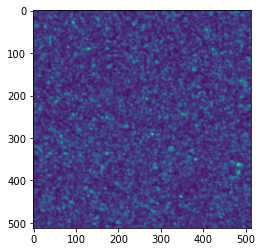

In [116]:
## Load in data
imgname='20p_HSgel_405laser_1au_10xobj_singledir_2xavg'
foldername='/Volumes/WENYUN WANG/20221129/gel_20p_HS/'
#framespeed=video_time_length/video_frame_numbers
img=read_in_data(foldername,imgname)

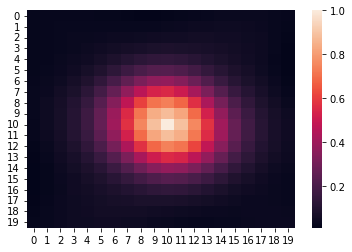

In [117]:
img_20=img[20]
ROI=[0,0,300,200] #y,x,w,h
sp_shape=20
spmap=spatial_correlation(img_20,sp_shape,ROI)

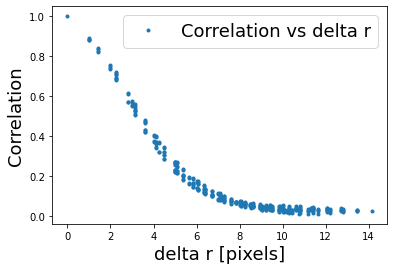

In [118]:
plot_spmap(spmap)

speckle size is: 4.4478395678802825
y = -0.05055 * x


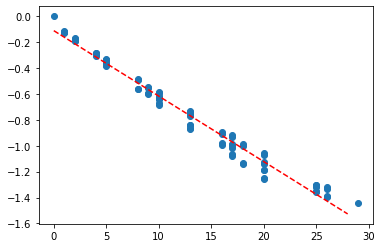

The size is :4.4478395678802825 pixel
The size is :0.4914251143952847 um


In [119]:

size,a =calculate_speckle_size(spmap,0,80)

scale=9.0509
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

#### 488 nm

##### 10x 0.52 au

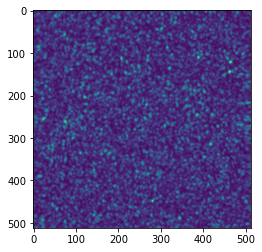

In [31]:
## Load in data
imgname='20p_HSgel_488laser_0p52au_10xobj_singledir_2xavg'
foldername='/Volumes/WENYUN WANG/20221129/gel_20p_HS/'
#framespeed=video_time_length/video_frame_numbers
img=read_in_data(foldername,imgname)

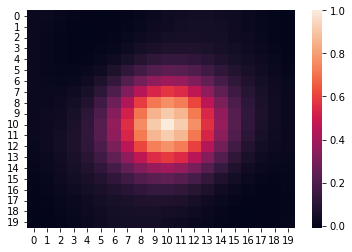

In [32]:
img_20=img[20]
ROI=[0,0,300,200] #y,x,w,h
sp_shape=20
spmap=spatial_correlation(img_20,sp_shape,ROI)

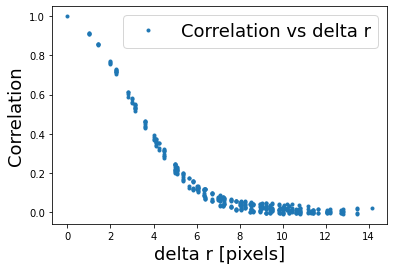

In [33]:
plot_spmap(spmap)

speckle size is: 4.188866969563491
y = -0.05699 * x


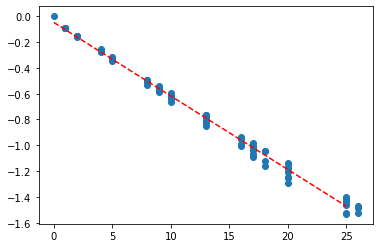

The size is :4.188866969563491 pixel
The size is :0.4628122031580827 um


In [34]:

size,a =calculate_speckle_size(spmap,0,80)

scale=9.0509
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

#### 639 nm

##### 0.53 au

In [93]:
#theoretical:
lam=405
theoretical=0.44*lam/1.2
print(theoretical)

148.5


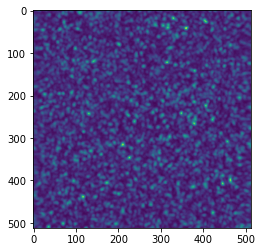

In [41]:
## Load in data
imgname='20p_HSgel_639laser_0p53au_10xobj_singledir_2xavg'
foldername='/Volumes/WENYUN WANG/20221129/gel_20p_HS/'
#framespeed=video_time_length/video_frame_numbers
img=read_in_data(foldername,imgname)

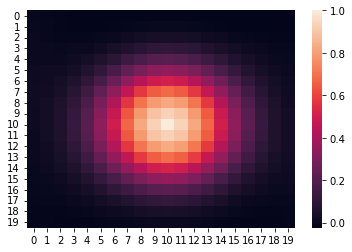

In [54]:
img_20=img[20]
ROI=[0,0,500,300] #y,x,w,h
sp_shape=20
spmap=spatial_correlation(img_20,sp_shape,ROI)

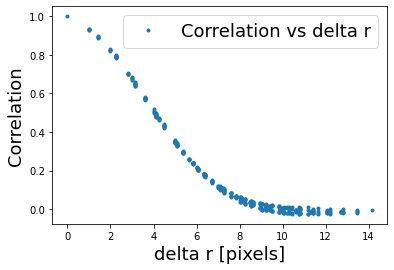

In [55]:
plot_spmap(spmap)

speckle size is: 4.763519629624261
y = -0.04407 * x


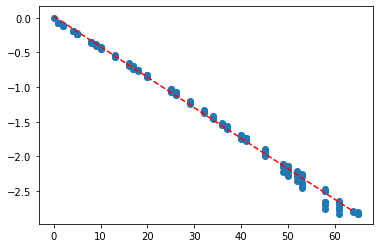

The size is :4.763519629624261 pixel
The size is :0.5263034206127856 um


In [59]:

size,a =calculate_speckle_size(spmap,0,200)

scale=9.0509
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

### 25x oil objective

#### 405 nm

##### 0.51 au

In [68]:
#theoretical:
n=1.51
lam=405
theoretical=0.44*lam/0.8
print(theoretical)

222.74999999999997


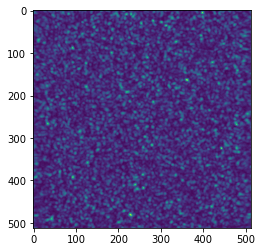

In [61]:
## Load in data
imgname='20p_HSgel_405laser_0p51au_25xoilobj_singledir_2xavg'
foldername='/Volumes/WENYUN WANG/20221129/gel_20p_HS/'
#framespeed=video_time_length/video_frame_numbers
img=read_in_data(foldername,imgname)

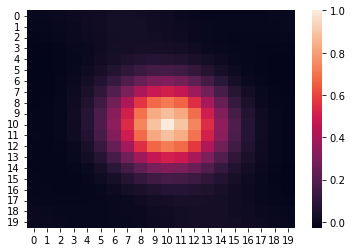

In [62]:
img_20=img[20]
ROI=[0,0,500,300] #y,x,w,h
sp_shape=20
spmap=spatial_correlation(img_20,sp_shape,ROI)

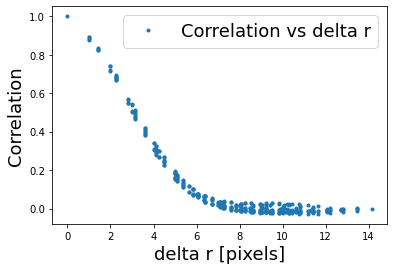

In [63]:
plot_spmap(spmap)

speckle size is: 3.821137634469872
y = -0.06849 * x


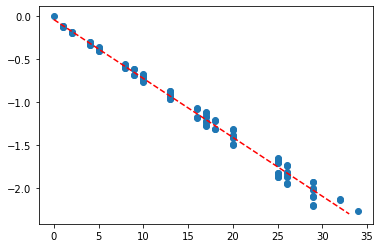

The size is :3.821137634469872 pixel
The size is :0.16887214768245012 um


In [65]:
size,a =calculate_speckle_size(spmap,0,100)

scale=22.6274
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

#### 639 nm

##### 0.52 au

In [74]:
#theoretical:
n=1.51
lam=639
theoretical=0.44*lam/0.8
print(theoretical)

351.45


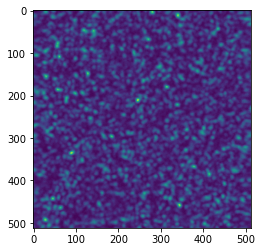

In [70]:
## Load in data
imgname='20p_HSgel_639laser_0p52au_25xoilobj_singledir_2xavg'
foldername='/Volumes/WENYUN WANG/20221129/gel_20p_HS/'
#framespeed=video_time_length/video_frame_numbers
img=read_in_data(foldername,imgname)

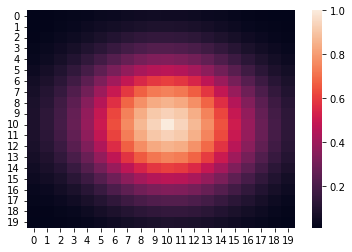

In [71]:
img_20=img[20]
ROI=[0,0,500,300] #y,x,w,h
sp_shape=20
spmap=spatial_correlation(img_20,sp_shape,ROI)

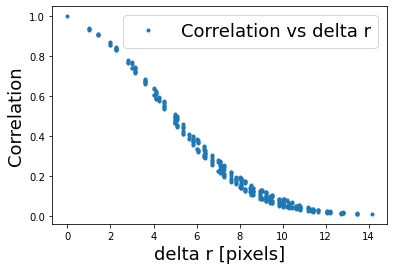

In [72]:
plot_spmap(spmap)

speckle size is: 6.087817798542582
y = -0.02698 * x


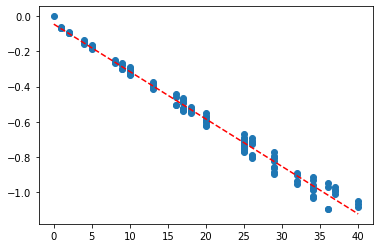

The size is :6.087817798542582 pixel
The size is :0.26904628010918535 um


In [75]:
size,a =calculate_speckle_size(spmap,0,120)

scale=22.6274
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

### 40x oil objective

#### 405 nm

##### 0.52 au

In [80]:
#theoretical:
lam=405
theoretical=0.44*lam/1.1
print(theoretical)

161.99999999999997


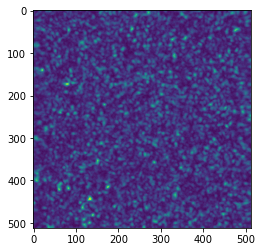

In [76]:
## Load in data
imgname='20p_HSgel_405laser_0p52au_40xoilobj_singledir_2xavg'
foldername='/Volumes/WENYUN WANG/20221129/gel_20p_HS/'
#framespeed=video_time_length/video_frame_numbers
img=read_in_data(foldername,imgname)

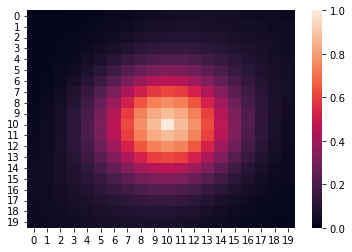

In [77]:
img_20=img[20]
ROI=[0,0,500,300] #y,x,w,h
sp_shape=20
spmap=spatial_correlation(img_20,sp_shape,ROI)

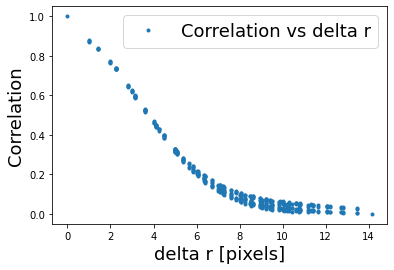

In [78]:
plot_spmap(spmap)

speckle size is: 4.972181478804973
y = -0.04045 * x


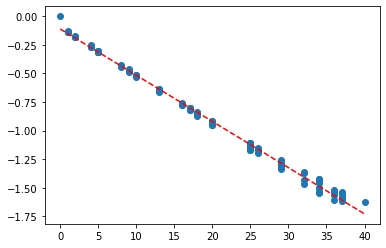

The size is :4.972181478804973 pixel
The size is :0.13733866275929524 um


In [79]:
size,a =calculate_speckle_size(spmap,0,120)

scale=36.2038
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

#### 639 nm

##### 0.52 au

In [85]:
#theoretical:
lam=639
theoretical=0.44*lam/1.1
print(theoretical)

255.6


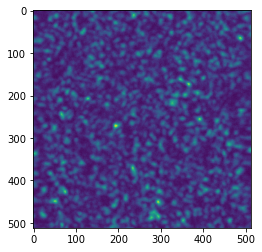

In [81]:
## Load in data
imgname='20p_HSgel_639laser_0p52au_40xoilobj_singledir_2xavg'
foldername='/Volumes/WENYUN WANG/20221129/gel_20p_HS/'
#framespeed=video_time_length/video_frame_numbers
img=read_in_data(foldername,imgname)

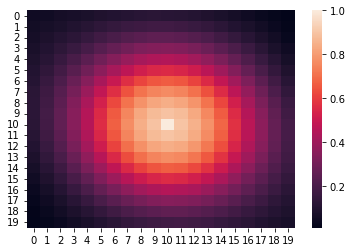

In [82]:
img_20=img[20]
ROI=[0,0,500,300] #y,x,w,h
sp_shape=20
spmap=spatial_correlation(img_20,sp_shape,ROI)

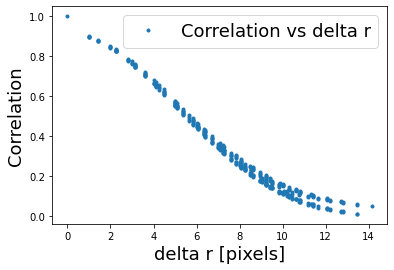

In [83]:
plot_spmap(spmap)

speckle size is: 7.162006878459726
y = -0.01950 * x


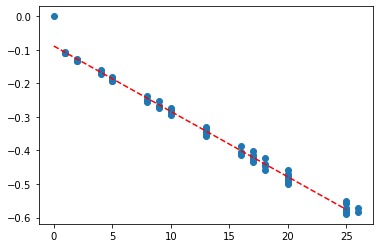

The size is :7.162006878459726 pixel
The size is :0.19782472774846083 um


In [87]:
size,a =calculate_speckle_size(spmap,0,80)

scale=36.2038
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

### 63x oil objective

#### 405 nm

##### 0.53 au

In [99]:
#theoretical:
lam=405
theoretical=0.44*lam/1.2
print(theoretical)

148.5


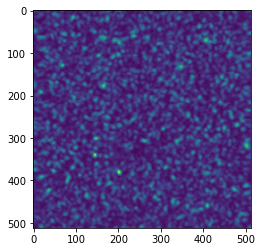

In [89]:
## Load in data
imgname='20p_HSgel_405laser_0p53au_63xoilobj_singledir_2xavg'
foldername='/Volumes/WENYUN WANG/20221129/gel_20p_HS/'
#framespeed=video_time_length/video_frame_numbers
img=read_in_data(foldername,imgname)

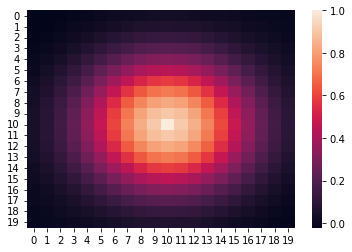

In [90]:
img_20=img[20]
ROI=[0,0,500,300] #y,x,w,h
sp_shape=20
spmap=spatial_correlation(img_20,sp_shape,ROI)

speckle size is: 6.01434383187057
y = -0.02765 * x


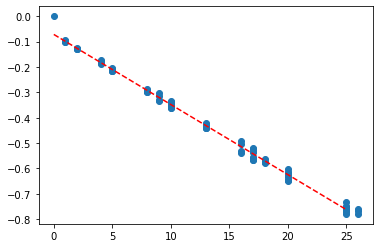

The size is :6.01434383187057 pixel
The size is :0.10547594450940127 um


In [91]:
size,a =calculate_speckle_size(spmap,0,80)

scale=57.0210
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

#### 639 nm

##### 0.52 au

In [101]:
#theoretical:
lam=639
theoretical=0.44*lam/1.2
print(theoretical)

234.30000000000004


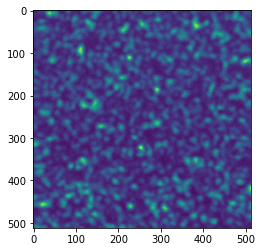

In [96]:
## Load in data
imgname='20p_HSgel_639laser_0p52au_63xoilobj_singledir_2xavg'
foldername='/Volumes/WENYUN WANG/20221129/gel_20p_HS/'
#framespeed=video_time_length/video_frame_numbers
img=read_in_data(foldername,imgname)

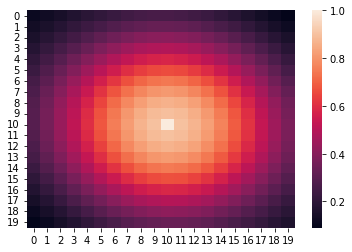

In [97]:
img_20=img[20]
ROI=[0,0,500,300] #y,x,w,h
sp_shape=20
spmap=spatial_correlation(img_20,sp_shape,ROI)

speckle size is: 9.135419051831335
y = -0.01198 * x


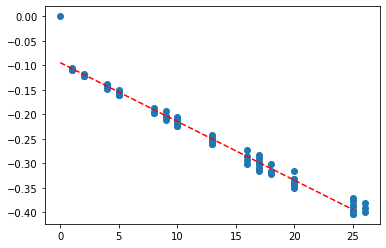

The size is :9.135419051831335 pixel
The size is :0.16021148439752608 um


In [98]:
size,a =calculate_speckle_size(spmap,0,80)

scale=57.0210
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

### b. correlation data

using 0.05% polystyrene beads in glycerol, compare the diffusion coefficient with the expected value (viscosity measured from rheometer)

### c. MSD of beads (higher magnification) (dilute beads)

## Figure 2